# Parse Garmin data
In this notebook there is the final method to parse my Garmin data, after [many attempts](https://github.com/francescolosterzo/parse-garmin-heartrate/blob/master/TestFitparse.ipynb). I will refer to this notebook several times.

The focus will be on heart rate data.

In [26]:
import fitparse
import sys
import datetime
import dateutil
import pytz

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def getUniqueValues(lst):
    return list( set(lst) )

## Load data
Here load the sample data. The folder downloaded from Garmin Connect has several files, after looking a bit into the files, I got the right one :)

In [2]:
input_file = '/Users/francesco/PersonalProjects/data/garmin/2019-05-01/33802246536.fit'
fitfile = fitparse.FitFile(input_file, data_processor=fitparse.StandardUnitsDataProcessor())

In [8]:
message_type = []
message_name = []

for record in fitfile.get_messages():
    
    message_type.append(record.type)
    message_name.append(record.name)

In [10]:
print('# of message types:', len(getUniqueValues(message_type)))
print(' -->', getUniqueValues(message_type))

# of message types: 1
 --> ['data']


In [11]:
print('# of message names:', len(getUniqueValues(message_name)))
print(' -->', getUniqueValues(message_name))

# of message names: 11
 --> ['unknown_233', 'ohr_settings', 'monitoring', 'software', 'unknown_24', 'stress_level', 'unknown_211', 'monitoring_info', 'event', 'device_info', 'file_id']


The `message` objects are all of type `'data'`, and there are 11 different names available.
Of all the `messages`, we are interested in those named `'monitoring'`.

The heart rate data are contained in `'monitoring'` message like this one:
```
name: monitoring
fields:[
{'name': 'timestamp_16', 'def_num': 26, 'base_type': 'uint16', 'type': 'uint16', 'units': 's', 'value': 31132, 'raw_value': 31132},
{'name': 'heart_rate', 'def_num': 27, 'base_type': 'uint8', 'type': 'uint8', 'units': 'bpm', 'value': 72, 'raw_value': 72}]
```
They indeed contain the heart rate value and a `timestamp_16`, which is a 16-bit timestamp. Looking at the [documentation](https://www.thisisant.com/forum/viewthread/6374/), the `timestamp_16` should be used together with the 32 `timestamp` preceeding it, contained in another `'monitoring'` message like this:
```
name monitoring
fields [
{'name': 'timestamp', 'def_num': 253, 'base_type': 'uint32', 'type': 'date_time', 'units': None, 'value': datetime.datetime(2019, 4, 30, 22, 0), 'raw_value': 925596000},
{'name': 'activity_type', 'def_num': 5, 'base_type': 'enum', 'type': 'activity_type', 'units': None, 'value': 'sedentary', 'raw_value': 8},
{'name': 'intensity', 'def_num': 28, 'base_type': 'uint8', 'type': 'uint8', 'units': None, 'value': 0, 'raw_value': 0},
{'name': 'current_activity_type_intensity', 'def_num': 24, 'base_type': 'byte', 'type': 'byte', 'units': None, 'value': (8,), 'raw_value': (8,)}]
```

The way `timestamp` and `timestamp_16` should be combined is not straightforward.

In [33]:
def getActualTimestamp(ts, ts16, isRaw=True):
    '''
    combine ts and ts_16 to get the actual timestamp
    '''
    
    tz = pytz.timezone('UTC')
    utc_offset = int(datetime.datetime.timestamp(datetime.datetime(1989,12,31,tzinfo=tz)))
    
    out = ts
    if not isRaw:
        out =- utc_offset
    
    out += ( ts16 - ( out & 0xFFFF ) ) & 0xFFFF

    return out + utc_offset

In [45]:
ts = getActualTimestamp(925596000, 31132)

In [46]:
#datetime.datetime.fromtimestamp(ts)

datetime.datetime(2019, 5, 1, 0, 1)

In [47]:
ts = 0
ts16 = 0

tsList = []
hrList = []

for record in fitfile.get_messages():
    
    if record.name != 'monitoring': continue
    
    this_record = record.as_dict()
    
    hr = None
    for field in this_record['fields']:
        
        # get the timestamp
        if field['name'] == 'timestamp':
            ts = field['raw_value']
        
        # if the monitoring object is about heart rate, take timestamp_16 and heart_rate
        if field['name'] == 'timestamp_16':
            ts16 = field['raw_value']
        
        if field['name'] == 'heart_rate':
            hr = field['raw_value']
    ##
    if not hr is None:
        #print(ts, ts16)
        hrList.append(hr)
        tsList.append(getActualTimestamp(ts, ts16))     

Dump data into a dataframe

In [64]:
df = pd.DataFrame({
    'utc_timestamp': tsList,
    'heartrate': hrList
})

In [65]:
df['datetime'] = pd.to_datetime(df['utc_timestamp'], unit='s')

In [66]:
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Europe/Zurich'))

In [67]:
df['datetime'] = df['datetime'].map(convert_tz).apply(lambda x: x.tz_localize(None))

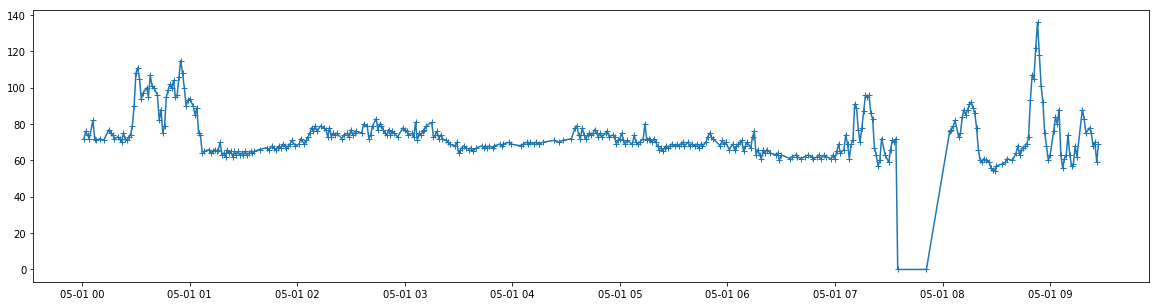

In [68]:
plt.figure(figsize=(20,5))

plt.plot( df.datetime, df.heartrate, marker='+' )

Yesss!!!!